# Transaction Fraud Detectation Project -- Modeling
The 'card transactions.csv' is a very big dataset, if I try to conduct every process all in one Jupyter Notebook, it will cause my kernel to die. So I separate the steps into several notebooks and deal with the process one by one. And this notebook is for <b>modeling</b>.

This notebook addresses a binary classification problem, utilizing various modeling algorithms. It reads a file generated from a feature selection process, containing a limited set of valuable variables with known multivariate importance. The notebook explores input variables, model algorithms, and hyperparameter tuning. The goal is to select a preferred algorithm, rerun it, and construct final model performance score percentile tables. The term "goods" represents the larger fraction of the population, while "bads" represent the smaller fraction, with the notebook originally designed for fraud detection but applicable to any binary classification task. Manual cross-validation is employed, running each model multiple times and averaging performance metrics across training, testing, and out-of-time datasets. You can comment out specific cells or models based on their preferences and computational requirements (some models take a long time to run, but their performance is not apparently better). Finally, you can choose a final model and hyperparameters for a one-time run, generating business performance tables.

In [2]:
from datetime import datetime
start_time = datetime.now()
import pandas as pd
import xgboost as xgb
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from sklearn.decomposition import PCA
import gc
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt 
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

/Users/lily/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
%%time
vars_all = pd.read_csv('vars_final.csv')

print(vars_all.shape)
vars_all.head()

(96397, 32)
CPU times: user 369 ms, sys: 82.8 ms, total: 452 ms
Wall time: 482 ms


,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1,...,merch_zip_med_1,Merchnum_med_1,Merchnum_desc_med_1,Merchnum_desc_med_3,Card_Merchnum_desc_med_60,card_zip_med_30,card_merch_avg_14,Card_Merchdesc_med_60,Recnum,Fraud
0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,1,0
1,31.42,31.42,1,31.42,31.42,31.42,31.42,31.42,31.42,31.42,...,31.42,31.42,31.42,31.42,31.42,31.42,31.42,31.42,2,0
2,178.49,178.49,1,178.49,178.49,178.49,178.49,178.49,178.49,178.49,...,178.49,178.49,178.49,178.49,178.49,178.49,178.49,178.49,3,0
3,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,4,0
4,7.24,3.62,2,3.62,3.62,3.62,3.62,3.62,3.62,3.62,...,3.62,3.62,3.62,3.62,3.62,3.62,3.62,3.62,5,0


In [4]:
# set the number of variables desired here
# vars_all's column order reflects the sequential process of constructing the wrapper
# the smaller the column number, the more important the variable is for prediction
NVARS = 10
numvars = min(NVARS,len(vars_all)-2) # 10
final_vars_list = ['Recnum','Fraud']
for i in range(numvars):
    final_vars_list.append(vars_all.columns[i])
    
final_vars_list

['Recnum',
 'Fraud',
 'card_merch_total_14',
 'card_zip3_max_14',
 'Card_Merchdesc_count_7',
 'Merchnum_desc_max_0',
 'zip3_avg_1',
 'Card_Merchnum_desc_avg_30',
 'Card_Merchdesc_avg_14',
 'card_merch_avg_7',
 'card_zip3_med_14',
 'zip3_med_1']

In [5]:
vars = vars_all.filter(final_vars_list,axis=1) #subset the dataframe rows or cols
vars.head()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1
0,1,0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,1,31.42,31.42,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,1,178.49,178.49,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,1,3.62,3.62,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,2,3.62,3.62,3.62,3.62,3.62,3.62,3.62


In [6]:
vars.shape

(96397, 12)

In [7]:
vars['Fraud'].sum()

1059

In [8]:
vars.head(10)

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1
0,1,0,3.62,3.62,1,3.62,3.620000,3.62,3.62,3.62,3.62,3.62
1,2,0,31.42,31.42,1,31.42,31.420000,31.42,31.42,31.42,31.42,31.42
2,3,0,178.49,178.49,1,178.49,178.490000,178.49,178.49,178.49,178.49,178.49
3,4,0,3.62,3.62,1,3.62,3.620000,3.62,3.62,3.62,3.62,3.62
4,5,0,7.24,3.62,2,3.62,3.620000,3.62,3.62,3.62,3.62,3.62
5,6,0,3.67,3.67,1,3.67,3.632500,3.67,3.67,3.67,3.67,3.62
6,7,0,3.62,3.62,1,3.62,3.630000,3.62,3.62,3.62,3.62,3.62
7,8,0,230.32,230.32,1,230.32,230.320000,230.32,230.32,230.32,230.32,230.32
8,9,0,62.11,62.11,1,62.11,62.110000,62.11,62.11,62.11,62.11,62.11
9,10,0,10.86,3.62,3,3.62,3.628333,3.62,3.62,3.62,3.62,3.62


In [10]:
vars.describe()

,Recnum,Fraud,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,48365.481820,0.010986,769.967286,529.353162,2.096186,494.222404,397.662863,403.854551,402.025227,399.930390,386.664184,302.369689
std,27945.003883,0.104236,4168.214517,1086.568630,3.836431,996.618365,611.330947,784.922248,788.088396,793.236155,769.876610,576.705188
min,1.000000,0.000000,0.010000,0.010000,1.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,24154.000000,0.000000,77.000000,57.190000,1.000000,46.880000,93.596667,42.536667,40.490000,38.360000,40.970000,57.440000
50%,48365.000000,0.000000,236.920000,212.660000,1.000000,187.500000,266.670769,165.000000,158.420000,150.330000,150.780000,161.170000
75%,72578.000000,0.000000,676.860000,609.000000,2.000000,566.720000,500.889412,462.650000,453.600000,447.400000,427.020000,330.500000
max,96753.000000,1.000000,306633.410000,47900.000000,90.000000,47900.000000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000


In [11]:
# use another variable to save record number and fraud label
record_save = vars['Recnum']
Y_save = pd.DataFrame(vars.loc[:,'Fraud'])
Y_save.head()

,Fraud
0,0
1,0
2,0
3,0
4,0


## Scale and truncate field values

In [12]:
X_no_scaling = vars.drop(columns = ['Recnum','Fraud'])
X_no_scaling.describe()

,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1
count,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000,96397.000000
mean,769.967286,529.353162,2.096186,494.222404,397.662863,403.854551,402.025227,399.930390,386.664184,302.369689
std,4168.214517,1086.568630,3.836431,996.618365,611.330947,784.922248,788.088396,793.236155,769.876610,576.705188
min,0.010000,0.010000,1.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,77.000000,57.190000,1.000000,46.880000,93.596667,42.536667,40.490000,38.360000,40.970000,57.440000
50%,236.920000,212.660000,1.000000,187.500000,266.670769,165.000000,158.420000,150.330000,150.780000,161.170000
75%,676.860000,609.000000,2.000000,566.720000,500.889412,462.650000,453.600000,447.400000,427.020000,330.500000
max,306633.410000,47900.000000,90.000000,47900.000000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000,28392.840000


In [13]:
# z-scale
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()

In [14]:
# use this to cap variables. For some problems it helps
Clip = 10

In [15]:
# push in any outlier values, then rescale
X.clip(-1*Clip,Clip,inplace=True) # Clip (limit) the values in an array.
# Now redo the zscaling after clipping
X = (X_no_scaling - X_no_scaling.mean()) / X_no_scaling.std()
X.describe()

,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1
count,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04,9.639700e+04
mean,-4.580238e-16,1.642357e-15,-2.065933e-15,-3.022288e-15,-3.993849e-15,-2.789133e-16,1.529972e-15,1.109360e-14,-8.195181e-15,-2.745702e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.847211e-01,-4.871696e-01,-2.857305e-01,-4.958893e-01,-6.504707e-01,-5.145026e-01,-5.101144e-01,-5.041631e-01,-5.022288e-01,-5.242881e-01
25%,-1.662504e-01,-4.345452e-01,-2.857305e-01,-4.488603e-01,-4.973839e-01,-4.603232e-01,-4.587496e-01,-4.558168e-01,-4.490254e-01,-4.247052e-01
50%,-1.278838e-01,-2.914617e-01,-2.857305e-01,-3.077631e-01,-2.142736e-01,-3.043035e-01,-3.091090e-01,-3.146609e-01,-3.063922e-01,-2.448386e-01
75%,-2.233745e-02,7.330125e-02,-2.507162e-02,7.274359e-02,1.688554e-01,7.490608e-02,6.544288e-02,5.984297e-02,5.241855e-02,4.877763e-02
max,7.337997e+01,4.359655e+01,2.291291e+01,4.756663e+01,4.579382e+01,3.565829e+01,3.551735e+01,3.528950e+01,3.637749e+01,4.870854e+01


In [16]:
# separate data into modeling (trntst) and out of time. 
# Here I use the record number to do this separation.
oot_recnum= 83970 # out_of_time data
X_trntst = X[0:oot_recnum]
Y_trntst = Y_save[0:oot_recnum]
X_oot = X[oot_recnum:]
Y_oot = Y_save[oot_recnum:]

## Explore regularization

Solve a linear regression with ridge and lasso regularization and watch how the variable weights evolve with the regularization strength

In [17]:
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV 
from sklearn.metrics import mean_squared_error

In [18]:
alphas = 10**np.linspace(2,9,30)*0.5 
# Returns num evenly spaced samples, calculated over the interval [start, stop].
# [stary,stop,num]

In [19]:
# train and test sets are both from in sample data "trntst"
X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

In [20]:
ridge = Ridge()
coefs = []
for a in alphas: 
    ridge.set_params(alpha=a) 
    ridge.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(ridge.coef_) 
np.shape(coefs)

(30, 10)

CPU times: user 587 ms, sys: 67.7 ms, total: 655 ms
Wall time: 429 ms


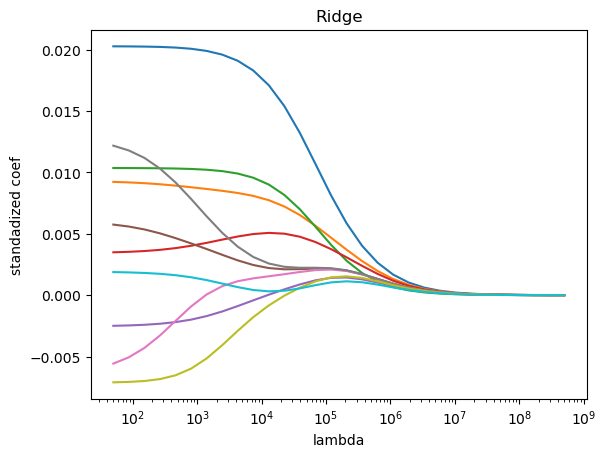

In [21]:
%%time
%matplotlib inline
ax = plt.gca() # Get the current Axes instance
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda') 
plt.ylabel('standadized coef') 
plt.title('Ridge')
plt.savefig('ridge.png')

In [22]:
alphas = 10**np.linspace(-5,0,30)*0.5

In [23]:
%%time
# sometimes this cell takes a long time
lasso = Lasso(max_iter=10000) 
coefs = [] 
for a in alphas: 
    lasso.set_params(alpha=a) 
    lasso.fit(X_trn,Y_trn.values.ravel()) 
    coefs.append(lasso.coef_) 
# print('Shape:',np.shape(coefs)
print('Selected Features:', list(vars.columns[np.where(lasso.coef_!=0)[0]]))

Selected Features: []
CPU times: user 2.81 s, sys: 42.9 ms, total: 2.85 s
Wall time: 738 ms


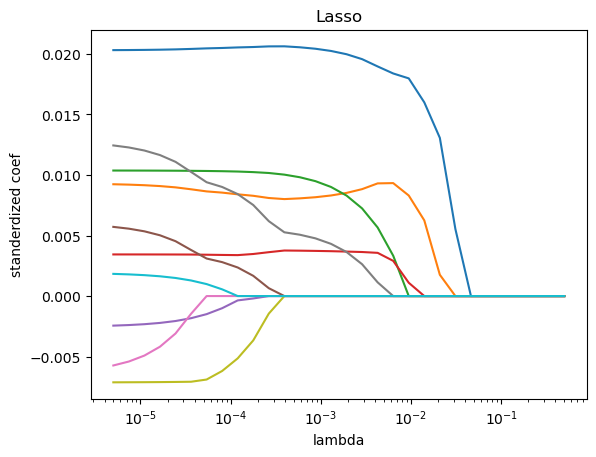

In [24]:
%matplotlib inline
ax = plt.gca() # Get the current Axes instance 
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('lambda')
plt.ylabel('standerdized coef') 
plt.title('Lasso')
#plt.legend()
plt.savefig('lasso.png')

## PCA

In [25]:
len(X_trntst.columns)

10

In [26]:
X_trntst_save = X_trntst.copy()

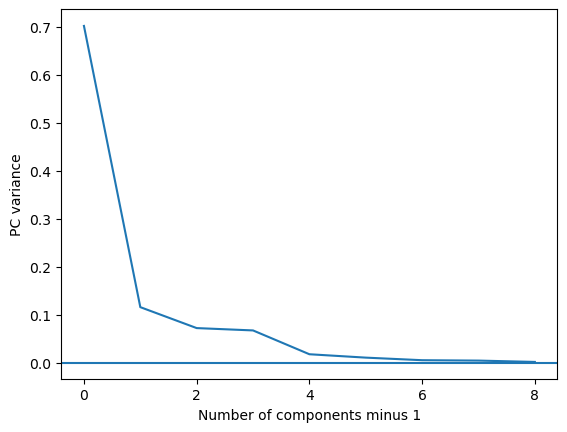

In [27]:
pca = PCA(n_components = .999, svd_solver = 'full')
pca.fit(X_trntst)
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('Number of components minus 1')
plt.ylabel('PC variance')
plt.xticks(np.arange(0, len(X_trntst.columns), step=2))
plt.axhline(y=0,xmin=0,xmax=len(X_trntst.columns))
X_trntst = X_trntst_save.copy()

In [28]:
# We look at the above picture, select how many PCs we want to keep, and then redo the PCA with just this many PCs
pca = PCA(n_components = 6, svd_solver = 'full')
princ_comps = pca.fit_transform(X_trntst)
X_trntst_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)])
X_trntst_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-1.469281,-0.043481,-0.274539,0.249205,-0.057553,-0.065145
1,-1.369538,-0.061655,-0.250727,0.242236,-0.059549,-0.065690
2,-0.841871,-0.157799,-0.124757,0.205367,-0.070112,-0.068571
3,-1.469281,-0.043481,-0.274539,0.249205,-0.057553,-0.065145
4,-1.471118,0.118448,-0.197658,0.060159,-0.051667,-0.059819


In [29]:
princ_comps = pca.transform(X_oot)
# execute a function for each value of the DataFrame
X_oot_orig_pca = pd.DataFrame(princ_comps, columns = ['PC' + str(i) for i in range(1, pca.n_components_+1)],index=X_oot.index)
X_oot_orig_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6
83970,-0.829278,-0.160093,-0.121751,0.204487,-0.070364,-0.068640
83971,-0.792579,-0.120148,-0.154351,0.224170,-0.105134,-0.058060
83972,-1.221416,-0.054179,-0.268701,0.242220,-0.084751,0.051627
83973,-0.999981,-0.084682,0.115980,0.378447,-0.098197,0.367149
83974,-1.133636,-0.104638,-0.194410,0.225753,-0.064271,-0.066978


In [30]:
X_trntst.describe()

,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1
count,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000,83970.000000
mean,0.003015,0.001960,-0.004609,0.004850,0.003128,0.002652,0.002985,0.003232,0.002698,0.001783
std,1.058833,1.010735,0.929489,1.010963,0.992446,0.996645,0.999297,1.000552,0.996740,0.989783
min,-0.184721,-0.487170,-0.285731,-0.495889,-0.650471,-0.514503,-0.510114,-0.504163,-0.502229,-0.524288
25%,-0.166286,-0.436791,-0.285731,-0.450897,-0.502646,-0.463542,-0.460628,-0.458540,-0.451063,-0.428069
50%,-0.127625,-0.293058,-0.285731,-0.308872,-0.209978,-0.304546,-0.309201,-0.314749,-0.306223,-0.242363
75%,-0.022093,0.074799,-0.025072,0.080048,0.173503,0.078282,0.068447,0.063048,0.055343,0.051851
max,73.379967,43.596553,15.614463,47.566631,45.793816,35.658290,35.517354,35.289503,36.377486,48.708545


In [31]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,-0.068071,0.014961,0.011632,-0.031113,-0.012754,0.011249
std,2.577780,1.084487,0.929712,0.987796,0.414996,0.396701
min,-1.504184,-17.834251,-24.775958,-15.737529,-6.474374,-3.853450
25%,-1.156461,-0.243845,-0.250939,-0.003473,-0.084543,-0.075365
50%,-0.739940,-0.117994,-0.096665,0.180575,-0.059939,-0.058178
75%,0.151320,-0.002929,0.181846,0.250591,-0.014429,-0.004345
max,96.172174,15.418409,27.560717,5.672832,20.956334,18.873043


In [32]:
# zscale the PCs (PC: principle components)
mean = X_trntst_pca.mean()
stdev = X_trntst_pca.std()
X_trntst_pca = (X_trntst_pca - mean)/stdev
X_oot_orig_pca = (X_oot_orig_pca - mean)/stdev

In [33]:
X_trntst_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,8.397000e+04,8.397000e+04,8.397000e+04,8.397000e+04,8.397000e+04,8.397000e+04
mean,-4.564277e-16,-4.504323e-17,-3.921215e-17,-9.748993e-18,1.197896e-16,7.198468e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-5.992736e-01,-1.728380e+01,-4.059948e+01,-1.704195e+01,-3.118373e+01,-2.589309e+01
25%,-4.570683e-01,-2.321270e-01,-3.029258e-01,-2.991750e-02,-1.967241e-01,-2.294253e-01
50%,-2.727797e-01,-1.048117e-01,-1.099266e-01,2.122877e-01,-1.381883e-01,-1.768235e-01
75%,9.029230e-02,2.727705e-02,2.312450e-01,3.090609e-01,-2.546970e-02,-1.037261e-02
max,3.793747e+01,5.189764e+01,4.173822e+01,4.176183e+01,4.988616e+01,5.894074e+01


In [34]:
X_oot_orig_pca.describe()

,PC1,PC2,PC3,PC4,PC5,PC6
count,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000,12427.000000
mean,-0.025725,0.013900,0.013677,-0.037881,-0.030091,0.034010
std,0.974171,1.007622,1.093218,1.202698,0.979103,1.199351
min,-0.568448,-16.570214,-29.133230,-19.161347,-15.275030,-11.650189
25%,-0.437039,-0.226562,-0.295070,-0.004228,-0.199462,-0.227852
50%,-0.279631,-0.109631,-0.113665,0.219861,-0.141414,-0.175890
75%,0.057186,-0.002721,0.213827,0.305109,-0.034041,-0.013135
max,36.344518,14.325600,32.407736,6.906999,49.442409,57.059133


In [35]:
X_trntst_pca.shape

(83970, 6)

In [36]:
X_oot_orig_pca.shape

(12427, 6)

## Subsample the larger class if desired

In [37]:
# set the ratio of goods to bads that you would like. This next line is the ratio of goods to bads that you want for modeling
sample_ratio_desired = 1

temp = X_trntst.copy()
temp['Fraud'] = Y_trntst['Fraud']
temp.head()
goods = temp[temp['Fraud']==0]
bads = temp[temp['Fraud']==1]
actual_bad_fraction = len(bads)/len(temp)
actual_good_fraction = 1 - actual_bad_fraction
print(actual_bad_fraction)
fraction = sample_ratio_desired * actual_bad_fraction
goods_sampled = goods.sample(frac = fraction)
all_sampled = pd.concat([goods_sampled,bads])
all_sampled.sort_index(inplace=True) 
Y_trntst_sampled = pd.DataFrame(all_sampled['Fraud'])
X_trntst_sampled = all_sampled.drop(columns=['Fraud'])
del [temp,goods,bads,all_sampled]
gc.collect() # a blocking garbage collection of all generations
print(X_trntst_sampled.shape,len(Y_trntst_sampled))

0.010479933309515303
(1751, 10) 1751


In [38]:
niter = 0
nitermax = 10 #run each model for nitermax times
X_oot_orig = X_oot.copy()
pd.options.mode.chained_assignment = None  # default='warn'

## Models

I commented out some models because they have a high computational requirement and don't seem to have much better performance than other models.

In [39]:
Modeling_output = pd.DataFrame(columns=['Model','Trn','Tst','OOT'],index=range(1000))
counter = 0
model_counter = 0

In [40]:
%%time
# Logistic regression

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = LogisticRegression(max_iter=20,penalty= 'elasticnet', solver='saga', C = 0.5,
                                                l1_ratio = 0.5)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())
    # numpy.ravel(): A 1-D array, containing the elements of the input, is returned. 

    predictions = model.predict_proba(X_trn_save)[:,1] # returns the class probabilities for each data point
    # return the possibility to be fraudulent
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])
    
    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['log reg',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.6097560975609756 0.6452830188679245 0.441340782122905
1 0.6359143327841845 0.6007326007326007 0.49162011173184356
2 0.6028708133971292 0.6640316205533597 0.4022346368715084
3 0.6110210696920584 0.6159695817490495 0.39106145251396646
4 0.6157480314960629 0.6163265306122448 0.4972067039106145
5 0.6221864951768489 0.6124031007751938 0.4245810055865922
6 0.6205211726384365 0.6203007518796992 0.4581005586592179
7 0.6161290322580645 0.6307692307692307 0.43575418994413406
8 0.6112903225806452 0.6384615384615384 0.4692737430167598
9 0.6201298701298701 0.6212121212121212 0.40782122905027934
trn    0.616557
tst    0.626549
oot    0.441899
dtype: float64
CPU times: user 6.61 s, sys: 765 ms, total: 7.38 s
Wall time: 3.74 s


In [41]:
%%time
# Single Decision Tree

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = DecisionTreeClassifier(criterion = 'entropy',
                                                   splitter = 'best',
                                                   max_depth = 3,
                                                   min_samples_split=5,
                                                   min_samples_leaf=5)
 
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['DT',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1

print(FDR3.mean())
model_counter = model_counter + 1

0 0.6413223140495867 0.6363636363636364 0.4972067039106145
1 0.6618122977346278 0.5992366412213741 0.4022346368715084
2 0.6639344262295082 0.674074074074074 0.39664804469273746
3 0.6726677577741408 0.6617100371747212 0.39106145251396646
4 0.6550079491255962 0.6653386454183267 0.5139664804469274
5 0.6380165289256199 0.6545454545454545 0.5083798882681564
6 0.6518151815181518 0.6496350364963503 0.5195530726256983
7 0.6366612111292962 0.6282527881040892 0.48044692737430167
8 0.6388888888888888 0.664179104477612 0.5139664804469274
9 0.6470588235294118 0.6653386454183267 0.5083798882681564
trn    0.650719
tst    0.649867
oot    0.473184
dtype: float64
CPU times: user 2.35 s, sys: 118 ms, total: 2.47 s
Wall time: 2.24 s


In [42]:
%%time
# Random Forest

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = RandomForestClassifier(criterion = 'gini',
                                                   n_estimators=10,
                                                   max_depth=5,
                                                   min_samples_split=30,
                                                   min_samples_leaf=30)
    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['RF',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7565359477124183 0.6977611940298507 0.5418994413407822
1 0.7557755775577558 0.718978102189781 0.5251396648044693
2 0.7543581616481775 0.7710843373493976 0.5307262569832403
3 0.7358803986710963 0.737410071942446 0.3687150837988827
4 0.7294685990338164 0.722007722007722 0.547486033519553
5 0.740983606557377 0.737037037037037 0.553072625698324
6 0.7744945567651633 0.8016877637130801 0.5251396648044693
7 0.740924092409241 0.7226277372262774 0.5418994413407822
8 0.7588996763754046 0.7557251908396947 0.44692737430167595
9 0.7607260726072608 0.7335766423357665 0.547486033519553
trn    0.750805
tst    0.739790
oot    0.512849
dtype: float64
CPU times: user 6.1 s, sys: 144 ms, total: 6.24 s
Wall time: 6.33 s


In [43]:
%%time
# LGBM

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = lgb.LGBMClassifier(boosting_type = 'gbdt',
                                               colsample_bytree =0.8,
                                               n_estimators=20,
                                               num_leaves=5,
                                               max_depth=8,
                                               subsample=0.8,
                                               learning_rate = 0.03)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7296 0.7215686274509804 0.5418994413407822
1 0.7382113821138211 0.720754716981132 0.5418994413407822
2 0.75 0.7095588235294118 0.5418994413407822
3 0.7277070063694268 0.75 0.553072625698324
4 0.7387820512820513 0.71875 0.5586592178770949
5 0.7371900826446282 0.7454545454545455 0.5307262569832403
6 0.7254901960784313 0.7276119402985075 0.5586592178770949
7 0.7024539877300614 0.7412280701754386 0.5586592178770949
8 0.7447833065810594 0.7392996108949417 0.547486033519553
9 0.7336601307189542 0.7276119402985075 0.547486033519553
trn    0.732788
tst    0.730184
oot    0.548045
dtype: float64
CPU times: user 9.02 s, sys: 613 ms, total: 9.63 s
Wall time: 1.49 s


In [44]:
%%time
# Neural Network

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = MLPClassifier(hidden_layer_sizes=(20,20,20),
                                          activation = 'relu',
                                          alpha = .01,
                                          learning_rate = 'constant',
                                          solver = 'adam',
                                          learning_rate_init = 0.0001)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['NN',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7169230769230769 0.6521739130434783 0.5251396648044693
1 0.6932907348242812 0.7362204724409449 0.5251396648044693
2 0.7147435897435898 0.66796875 0.5139664804469274
3 0.7034035656401945 0.7224334600760456 0.553072625698324
4 0.7092084006462036 0.685823754789272 0.5195530726256983
5 0.7217806041335453 0.701195219123506 0.46368715083798884
6 0.7084019769357496 0.6483516483516484 0.4692737430167598
7 0.7037643207855974 0.7063197026022305 0.41899441340782123
8 0.6666666666666666 0.6640316205533597 0.5195530726256983
9 0.7219512195121951 0.6792452830188679 0.4022346368715084
trn    0.706013
tst    0.686376
oot    0.491061
dtype: float64
CPU times: user 1min 41s, sys: 2.54 s, total: 1min 43s
Wall time: 1min 46s


In [45]:
# %%time
# # NN on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = MLPClassifier(hidden_layer_sizes=(2))

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['NN_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [46]:
%%time
# GBC (Gradient boosting)

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = GradientBoostingClassifier(max_depth= 6,n_estimators=20,
                                       learning_rate = 0.01,
                                       min_samples_split = 10,
                                       min_samples_leaf =5)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['GBC',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7215619694397284 0.6769759450171822 0.5083798882681564
1 0.7417218543046358 0.6521739130434783 0.4972067039106145
2 0.7245901639344262 0.6925925925925925 0.5418994413407822
3 0.7004754358161648 0.7028112449799196 0.5195530726256983
4 0.7581168831168831 0.7083333333333334 0.4134078212290503
5 0.6928104575163399 0.667910447761194 0.4692737430167598
6 0.7487684729064039 0.7490774907749077 0.553072625698324
7 0.7217806041335453 0.701195219123506 0.4748603351955307
8 0.717219589257504 0.7044534412955465 0.4134078212290503
9 0.729903536977492 0.7286821705426356 0.5139664804469274
trn    0.725695
tst    0.698421
oot    0.490503
dtype: float64
CPU times: user 59.3 s, sys: 993 ms, total: 1min
Wall time: 1min 8s


In [47]:
%%time
# Catboost

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = CatBoostClassifier(max_depth=5,iterations=5,learning_rate = 0.1,bootstrap_type = 'Bayesian',
                               l2_leaf_reg = 8)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['cat boost',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0:	learn: 0.6021266	total: 68.5ms	remaining: 274ms
1:	learn: 0.5272088	total: 72ms	remaining: 108ms
2:	learn: 0.4647965	total: 77.7ms	remaining: 51.8ms
3:	learn: 0.4123070	total: 81.8ms	remaining: 20.5ms
4:	learn: 0.3670796	total: 85.2ms	remaining: 0us
0 0.6381260096930533 0.6398467432950191 0.4301675977653631
0:	learn: 0.6020234	total: 6.59ms	remaining: 26.4ms
1:	learn: 0.5271752	total: 10.6ms	remaining: 15.8ms
2:	learn: 0.4646654	total: 13.3ms	remaining: 8.88ms
3:	learn: 0.4121097	total: 15.9ms	remaining: 3.98ms
4:	learn: 0.3668041	total: 20.5ms	remaining: 0us
1 0.6611570247933884 0.5963636363636363 0.3687150837988827
0:	learn: 0.6020943	total: 3.19ms	remaining: 12.8ms
1:	learn: 0.5272265	total: 6.27ms	remaining: 9.41ms
2:	learn: 0.4647728	total: 9.98ms	remaining: 6.65ms
3:	learn: 0.4122909	total: 13.6ms	remaining: 3.39ms
4:	learn: 0.3670657	total: 16.2ms	remaining: 0us
2 0.654281098546042 0.6091954022988506 0.4301675977653631
0:	learn: 0.6020404	total: 3.39ms	remaining: 13.6ms
1:	le

In [48]:
# %%time
# # NOTE this cell has been substantially modified to evaluate a sampled trn/tst data set. 
# # Only use this cell if you do downsampling of the goods.
# # each good needs to have a weight of (1-actual_ratio)/sample_ratio_desired
# # it's hard to get the correct FDR@3% for the actual train and test, so I just use the original trntst after the model is built for evaluation

# xmult = actual_good_fraction / (actual_bad_fraction * sample_ratio_desired)
# print(xmult)
# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_sampled, Y_trntst_sampled, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)

#     model.fit(X_trn, Y_trn.values.ravel())  
    
#     X_oot = X_oot_orig.copy()
#     X_trn = X_trntst.copy()
#     Y_trn = Y_trntst.copy()
#     X_tst = X_trntst.copy()
#     Y_tst = Y_trntst.copy()


#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_trntst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_trntst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_sampled',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [49]:
# %%time
# # Catboost on pc's

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     model = CatBoostClassifier(verbose=0, max_depth=2, iterations=5)


#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['cat boost_PCs',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [50]:
# %%time
# # unsupervised model using pc's. 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst_pca, Y_trntst, test_size = .3)

#     X_oot = X_oot_orig_pca.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     pow = 2
#     oop = 1/pow
#     predictions = ((X_trn.abs()**pow).sum(axis=1))**oop
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = ((X_tst.abs()**pow).sum(axis=1))**oop
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = ((X_oot.abs()**pow).sum(axis=1))**oop
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['unsupervised outliers',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [51]:
%%time
# XGB

FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(nitermax):  
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

    model = xgb.XGBClassifier(max_depth=6,n_estimators=20,booster = 'gbtree',
                            tree_method = 'exact',min_child_weight= 5,subsample = 1,
                            eta = 0.1,colsample_bytree = 1)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['XGB',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.78369384359401 0.7311827956989247 0.553072625698324
1 0.7512355848434926 0.8058608058608059 0.553072625698324
2 0.7957860615883307 0.7262357414448669 0.5195530726256983
3 0.7875210792580101 0.6933797909407665 0.553072625698324
4 0.7707006369426752 0.7380952380952381 0.5586592178770949
5 0.7693574958813838 0.7582417582417582 0.5642458100558659
6 0.7671009771986971 0.7744360902255639 0.5363128491620112
7 0.7613814756671899 0.7489711934156379 0.48044692737430167
8 0.7786624203821656 0.746031746031746 0.547486033519553
9 0.782392026578073 0.7410071942446043 0.40782122905027934
trn    0.774783
tst    0.746344
oot    0.527374
dtype: float64
CPU times: user 47.3 s, sys: 1.58 s, total: 48.8 s
Wall time: 8.32 s


In [52]:
# %%time
# # KNN 

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = KNeighborsClassifier(n_neighbors=50) 
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['Knn',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

In [53]:
# %%time
# # SVM
# # SVM can be very slow. It scales like the # training records cubed

# FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
# for niter in range(nitermax):  
#     X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

#     model = svm.SVC(
#         C=.1, 
# #         gamma=100,
# #         kernel='linear',
#         kernel='poly',
#         probability=True)
    
#     X_oot = X_oot_orig.copy()
#     X_trn_save = X_trn.copy()
#     Y_trn_save = Y_trn.copy()

#     model.fit(X_trn, Y_trn.values.ravel())   

#     predictions = model.predict_proba(X_trn_save)[:,1]
#     X_trn['predicted'] = predictions
#     X_trn['Fraud'] = Y_trn_save['Fraud']
#     topRows = int(round(X_trn.shape[0]*0.03))
#     temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_tst)[:,1]
#     X_tst['predicted']=predictions
#     X_tst['Fraud'] = Y_tst['Fraud']
#     topRows = int(round(X_tst.shape[0]*0.03))
#     temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

#     predictions = model.predict_proba(X_oot)[:,1]
#     X_oot['predicted']=predictions
#     X_oot['Fraud'] = Y_oot['Fraud']
#     topRows = int(round(X_oot.shape[0]*0.03))
#     temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
#     needed = temp.loc[:,'Fraud']
#     FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
#     print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
#     Modeling_output.iloc[counter] = ['SVM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
#     counter = counter + 1
    
# print(FDR3.mean())
# model_counter = model_counter + 1

## Model comparison plots

In [54]:
df = Modeling_output.dropna()
df.head(20)

,Model,Trn,Tst,OOT
0,log reg,0.609756,0.645283,0.441341
1,log reg,0.635914,0.600733,0.49162
2,log reg,0.602871,0.664032,0.402235
3,log reg,0.611021,0.61597,0.391061
4,log reg,0.615748,0.616327,0.497207
5,log reg,0.622186,0.612403,0.424581
6,log reg,0.620521,0.620301,0.458101
7,log reg,0.616129,0.630769,0.435754
8,log reg,0.61129,0.638462,0.469274
9,log reg,0.62013,0.621212,0.407821


In [55]:
df.shape

(80, 4)

In [56]:
indd = df[df['Model'] == 'NN'].index
df.drop(indd[0:-10], inplace = True)


In [57]:
df['Model'].unique()

array(['log reg', 'DT', 'RF', 'LGBM', 'NN', 'GBC', 'cat boost', 'XGB'],
      dtype=object)

In [58]:
df_unpivot = df.melt( id_vars='Model', value_vars=['Trn','Tst','OOT'], var_name=['Type'], value_name='Value')
df_unpivot.head()

,Model,Type,Value
0,log reg,Trn,0.609756
1,log reg,Trn,0.635914
2,log reg,Trn,0.602871
3,log reg,Trn,0.611021
4,log reg,Trn,0.615748


In [59]:
df_compare = df_unpivot[(df_unpivot['Type']=='Trn') | (df_unpivot['Type']=='Tst') | (df_unpivot['Type']=='OOT')]
df_compare.head()

,Model,Type,Value
0,log reg,Trn,0.609756
1,log reg,Trn,0.635914
2,log reg,Trn,0.602871
3,log reg,Trn,0.611021
4,log reg,Trn,0.615748


In [125]:
output = df.groupby('Model').agg({'Trn':['mean','std'],'Tst':['mean','std'],'OOT':['mean','std']})
output

Trn                 Tst                 OOT          
               mean       std      mean       std      mean       std
Model                                                                
DT         0.664035  0.013597  0.633042  0.023769  0.498324  0.047316
GBC        0.730577  0.019423  0.695994  0.030975  0.498883  0.055931
LGBM       0.736764  0.011686  0.725446  0.023686  0.539665  0.034759
NN         0.701221  0.018039  0.688219  0.029372  0.505587  0.047276
RF         0.749801  0.026515  0.740680  0.022979  0.502793  0.071689
XGB        0.769124  0.011472  0.757357  0.021506  0.534637  0.046967
cat boost  0.643462  0.027109  0.627656  0.031781  0.411732  0.092049
log reg    0.621061  0.013329  0.620710  0.034443  0.454190  0.044307

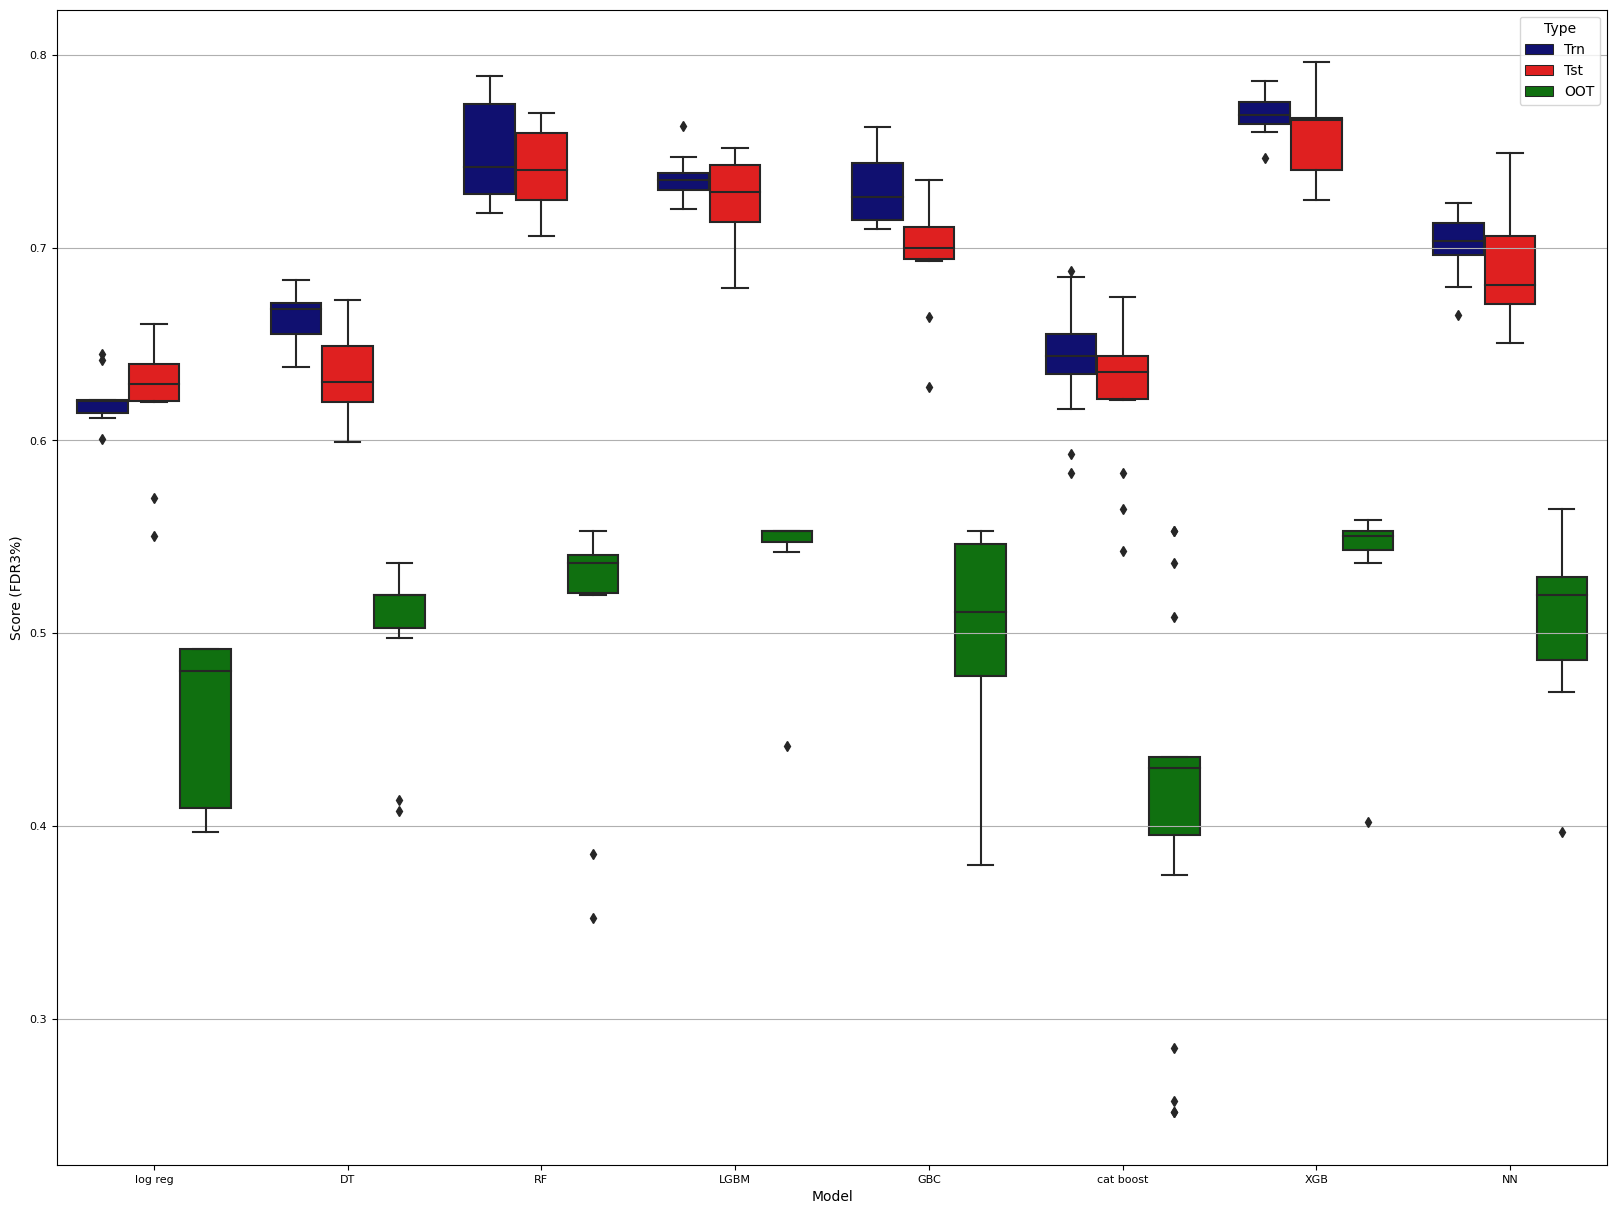

In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(20,15))
ax = sns.boxplot(x='Model',y='Value',hue='Type', data=df_compare, palette=['navy','r','g'])


plt.ylabel('Score (FDR3%)')
plt.grid(axis='y')
plt.savefig('modeling.png')   
plt.show()

In [ ]:
print('duration: ', datetime.now() - start_time)

## Final model

Generally, we can train the final model using all the data in trntst (all the data except the out_of_time (OOT) set, for model exploration, we manually shuffle it into training and test set to evaluate the models). However, because the pattern of OOT is abnormal, the data distribution is not the same as trntst. Therefore, we still want to keep the test set to make sure the final model can work well on normal patterns.

In [78]:
%%time
FDR3 = pd.DataFrame(np.zeros((nitermax,3)), columns=('trn', 'tst', 'oot'))
for niter in range(30):    
    X_trn, X_tst, Y_trn, Y_tst = train_test_split(X_trntst, Y_trntst, test_size = .3)

# here's where you put your final model of choice
    model = lgb.LGBMClassifier(boosting_type = 'gbdt',
                                               colsample_bytree =0.8,
                                               n_estimators=15,
                                               num_leaves=5,
                                               max_depth=8,
                                               subsample=0.8,
                                               learning_rate = 0.03)

    X_oot = X_oot_orig.copy()
    X_trn_save = X_trn.copy()
    Y_trn_save = Y_trn.copy()

    model.fit(X_trn, Y_trn.values.ravel())   

    predictions = model.predict_proba(X_trn_save)[:,1]
    X_trn['predicted'] = predictions
    X_trn['Fraud'] = Y_trn_save['Fraud']
    topRows = int(round(X_trn.shape[0]*0.03))
    temp = X_trn.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'trn'] = sum(needed)/sum(X_trn.loc[:,'Fraud'])

    predictions = model.predict_proba(X_tst)[:,1]
    X_tst['predicted']=predictions
    X_tst['Fraud'] = Y_tst['Fraud']
    topRows = int(round(X_tst.shape[0]*0.03))
    temp = X_tst.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'tst'] = sum(needed)/sum(X_tst.loc[:,'Fraud'])

    predictions = model.predict_proba(X_oot)[:,1]
    X_oot['predicted']=predictions
    X_oot['Fraud'] = Y_oot['Fraud']
    topRows = int(round(X_oot.shape[0]*0.03))
    temp = X_oot.sort_values('predicted',ascending=False).head(topRows)
    needed = temp.loc[:,'Fraud']
    FDR3.loc[niter, 'oot'] = sum(needed)/sum(X_oot.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot'])
    Modeling_output.iloc[counter] = ['LGBM',FDR3.loc[niter, 'trn'],FDR3.loc[niter, 'tst'],FDR3.loc[niter, 'oot']]
    counter = counter + 1
#     if(FDR3.loc[niter, 'oot'] > .56): break
    
print(FDR3.mean())
model_counter = model_counter + 1

0 0.7495826377295493 0.693950177935943 0.5307262569832403
1 0.7227891156462585 0.7294520547945206 0.5307262569832403
2 0.7389937106918238 0.6967213114754098 0.5307262569832403
3 0.7260940032414911 0.714828897338403 0.5363128491620112
4 0.7366720516962844 0.7126436781609196 0.547486033519553
5 0.734094616639478 0.6666666666666666 0.547486033519553
6 0.7351097178683386 0.7107438016528925 0.553072625698324
7 0.7386363636363636 0.696969696969697 0.5251396648044693
8 0.753577106518283 0.6972111553784861 0.5586592178770949
9 0.739424703891709 0.6885813148788927 0.5418994413407822
10 0.7194719471947195 0.7153284671532847 0.5363128491620112
11 0.7290969899665551 0.7304964539007093 0.5307262569832403
12 0.7391304347826086 0.7092198581560284 0.5307262569832403
13 0.7095709570957096 0.7007299270072993 0.547486033519553
14 0.7471451876019576 0.7116104868913857 0.5363128491620112
15 0.7079934747145188 0.7228464419475655 0.5418994413407822
16 0.747457627118644 0.7379310344827587 0.5307262569832403
1

In [79]:
X_trn_eval = X_trn.copy()
X_tst_eval = X_tst.copy()
X_oot_eval = X_oot.copy()

In [80]:
cols = ['bin','#recs','#g','#b','%g','%b','tot','cg','cb','%cg','FDR','KS','FPR']
FDR_trn = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_tst = pd.DataFrame(np.zeros((101, 13)), columns = cols)
FDR_oot = pd.DataFrame(np.zeros((101, 13)), columns = cols)
trn_sorted = X_trn_eval.sort_values('predicted',ascending=False)
tst_sorted = X_tst_eval.sort_values('predicted',ascending=False)
oot_sorted = X_oot_eval.sort_values('predicted',ascending=False)
bad_tot_trn = sum(X_trn_eval.loc[:, 'Fraud'])
bad_tot_tst = sum(X_tst_eval.loc[:, 'Fraud'])
bad_tot_oot = sum(X_oot_eval.loc[:, 'Fraud'])
num_tot_trn = len(X_trn_eval)
num_tot_tst = len(X_tst_eval)
num_tot_oot = len(X_oot_eval)
good_tot_trn = num_tot_trn - bad_tot_trn
good_tot_tst = num_tot_tst - bad_tot_tst
good_tot_oot = num_tot_oot - bad_tot_oot
oot_sorted.head(20)

,card_merch_total_14,card_zip3_max_14,Card_Merchdesc_count_7,Merchnum_desc_max_0,zip3_avg_1,Card_Merchnum_desc_avg_30,Card_Merchdesc_avg_14,card_merch_avg_7,card_zip3_med_14,zip3_med_1,predicted,Fraud
89183,9.722223,7.148446,5.448765,7.828882,1.528486,1.443541,1.440063,1.175114,0.713343,1.098447,0.465427,1
89174,9.315610,7.148446,5.188106,7.828882,1.508705,1.434396,1.430954,1.159870,0.683909,1.059155,0.465427,1
89130,9.112811,7.148446,4.927448,7.828882,1.613550,1.494006,1.490325,1.240671,0.765500,1.168076,0.465427,1
89186,9.768838,7.148446,5.709424,7.828882,1.470325,1.372270,1.369078,1.130291,0.683909,1.059155,0.465427,1
89057,3.313470,2.844300,1.799541,3.136263,0.814039,1.137306,1.135058,1.027653,1.048221,1.019863,0.445747,1
89060,3.537990,2.844300,2.060200,3.136263,0.817723,1.091352,1.089289,1.000573,1.020197,1.059155,0.445747,1
89120,6.526073,2.844300,4.145471,1.610564,1.256012,1.092240,1.090173,0.965124,0.765500,1.168076,0.445747,1
89121,6.919649,2.844300,4.406130,1.610564,1.287092,1.117675,1.115506,0.989077,0.817658,1.237704,0.445747,1
89128,7.032132,2.844300,4.666789,1.610564,1.242067,1.065932,1.063970,0.954377,0.765500,1.168076,0.445747,1
89114,6.341771,2.844300,3.624153,1.610564,1.372211,1.231915,1.229287,1.054676,0.918928,1.372894,0.445747,1


In [81]:
for i in range(101):
    percent_rows_trn = int(round(X_trn_eval.shape[0]*0.01*i))
    percent_rows_tst = int(round(X_tst_eval.shape[0]*0.01*i))
    percent_rows_oot = int(round(X_oot_eval.shape[0]*0.01*i))
    temp_trn = trn_sorted.head(percent_rows_trn)
    temp_tst = tst_sorted.head(percent_rows_tst)
    temp_oot = oot_sorted.head(percent_rows_oot)
    num_bad_trn = sum(temp_trn.loc[:,'Fraud'])
    num_bad_tst = sum(temp_tst.loc[:,'Fraud'])
    num_bad_oot = sum(temp_oot.loc[:,'Fraud'])
    num_tot_trn = len(temp_trn)
    num_tot_tst = len(temp_tst)
    num_tot_oot = len(temp_oot)
    num_good_trn = num_tot_trn - num_bad_trn
    num_good_tst = num_tot_tst - num_bad_tst
    num_good_oot = num_tot_oot - num_bad_oot
    
    FDR_trn.loc[i, 'bin'] = i
    FDR_trn.loc[i,'#recs'] = 0
    FDR_trn.loc[i, 'tot'] = num_tot_trn
    FDR_trn.loc[i, 'cg'] = num_good_trn
    FDR_trn.loc[i, 'cb'] = num_bad_trn
    FDR_tst.loc[i, 'bin'] = i
    FDR_tst.loc[i, 'tot'] = num_tot_tst
    FDR_tst.loc[i, 'cg'] = num_good_tst
    FDR_tst.loc[i, 'cb'] = num_bad_tst
    FDR_oot.loc[i, 'bin'] = i
    FDR_oot.loc[i, 'tot'] = num_tot_oot
    FDR_oot.loc[i, 'cg'] = num_good_oot
    FDR_oot.loc[i, 'cb'] = num_bad_oot
    if i != 0:
        FDR_trn.loc[i, '#g'] = num_good_trn - FDR_trn.loc[i-1, 'cg']
        FDR_trn.loc[i, '#b'] = num_bad_trn - FDR_trn.loc[i-1, 'cb']
        FDR_trn.loc[i,'#recs'] = FDR_trn.loc[i, '#g'] + FDR_trn.loc[i, '#b']
        FDR_trn.loc[i, '%g'] = 100* (num_good_trn - FDR_trn.loc[i-1, 'cg']) / (num_tot_trn - FDR_trn.loc[i-1, 'tot'])
        FDR_trn.loc[i, '%b'] = 100 - FDR_trn.loc[i, '%g']
        FDR_trn.loc[i, '%cg'] = 100 * num_good_trn / good_tot_trn
        FDR_trn.loc[i, 'FDR'] = 100 * num_bad_trn / bad_tot_trn
        FDR_trn.loc[i, 'KS'] = FDR_trn.loc[i, 'FDR'] - FDR_trn.loc[i, '%cg']
        FDR_trn.loc[i, 'FPR'] = num_good_trn / num_bad_trn
        FDR_tst.loc[i, '#g'] = num_good_tst - FDR_tst.loc[i-1, 'cg']
        FDR_tst.loc[i, '#b'] = num_bad_tst - FDR_tst.loc[i-1, 'cb']
        FDR_tst.loc[i,'#recs'] = FDR_tst.loc[i, '#g'] + FDR_tst.loc[i, '#b']
        FDR_tst.loc[i, '%g'] = 100* (num_good_tst - FDR_tst.loc[i-1, 'cg']) / (num_tot_tst - FDR_tst.loc[i-1, 'tot'])
        FDR_tst.loc[i, '%b'] = 100 - FDR_tst.loc[i, '%g']
        FDR_tst.loc[i, '%cg'] = 100 * num_good_tst / good_tot_tst
        FDR_tst.loc[i, 'FDR'] = 100 * num_bad_tst / bad_tot_tst
        FDR_tst.loc[i, 'KS'] = FDR_tst.loc[i, 'FDR'] - FDR_tst.loc[i, '%cg']
        FDR_tst.loc[i, 'FPR'] = num_good_tst / num_bad_tst
        FDR_oot.loc[i, '#g'] = num_good_oot - FDR_oot.loc[i-1, 'cg']
        FDR_oot.loc[i, '#b'] = num_bad_oot - FDR_oot.loc[i-1, 'cb']
        FDR_oot.loc[i,'#recs'] = FDR_oot.loc[i, '#g'] + FDR_oot.loc[i, '#b']
        FDR_oot.loc[i, '%g'] = 100* (num_good_oot - FDR_oot.loc[i-1, 'cg']) / (num_tot_oot - FDR_oot.loc[i-1, 'tot'])
        FDR_oot.loc[i, '%b'] = 100 - FDR_oot.loc[i, '%g']
        FDR_oot.loc[i, '%cg'] = 100 * num_good_oot / good_tot_oot
        FDR_oot.loc[i, 'FDR'] = 100 * num_bad_oot / bad_tot_oot
        FDR_oot.loc[i, 'KS'] = FDR_oot.loc[i, 'FDR'] - FDR_oot.loc[i, '%cg']
        FDR_oot.loc[i, 'FPR'] = num_good_oot / num_bad_oot

FDR_oot

,bin,#recs,#g,#b,%g,%b,tot,cg,cb,%cg,FDR,KS,FPR
0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000
1,1.0,124.0,64.0,60.0,51.612903,48.387097,124.0,64.0,60.0,0.522534,33.519553,32.997019,1.066667
2,2.0,125.0,93.0,32.0,74.400000,25.600000,249.0,157.0,92.0,1.281842,51.396648,50.114806,1.706522
3,3.0,124.0,117.0,7.0,94.354839,5.645161,373.0,274.0,99.0,2.237100,55.307263,53.070163,2.767677
4,4.0,124.0,123.0,1.0,99.193548,0.806452,497.0,397.0,100.0,3.241346,55.865922,52.624576,3.970000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,96.0,124.0,122.0,2.0,98.387097,1.612903,11930.0,11753.0,177.0,95.958524,98.882682,2.924158,66.401130
97,97.0,124.0,123.0,1.0,99.193548,0.806452,12054.0,11876.0,178.0,96.962769,99.441341,2.478571,66.719101
98,98.0,124.0,123.0,1.0,99.193548,0.806452,12178.0,11999.0,179.0,97.967015,100.000000,2.032985,67.033520
99,99.0,125.0,125.0,0.0,100.000000,0.000000,12303.0,12124.0,179.0,98.987590,100.000000,1.012410,67.731844


In [74]:
FDR3.to_csv('FDR_3.csv')

In [75]:
FDR_trn.to_csv('FDR_trn.csv', index=False)
FDR_tst.to_csv('FDR_tst.csv', index=False)
FDR_oot.to_csv('FDR_oot.csv', index=False)

In [76]:
print("duration: ", datetime.now() - start_time)

duration:  3:45:35.621642


## Set the score cutoff
Assume that \\$400 gain from every fraud that is caught, and \\$20 is lost when a normal transaction is labeled to be fraudulent (false positive). Based on the prediction results from running the final model, calculating the Fraud $’s Caught (green curve), Lost Revenue (red curve), and Overall Savings (blue curve) and showed those curves in the following plot to illustrate expected annual savings based on the percentage of transactions above score cutoff.


Max possible %: 3
Max possible savings: 20,472,000.0


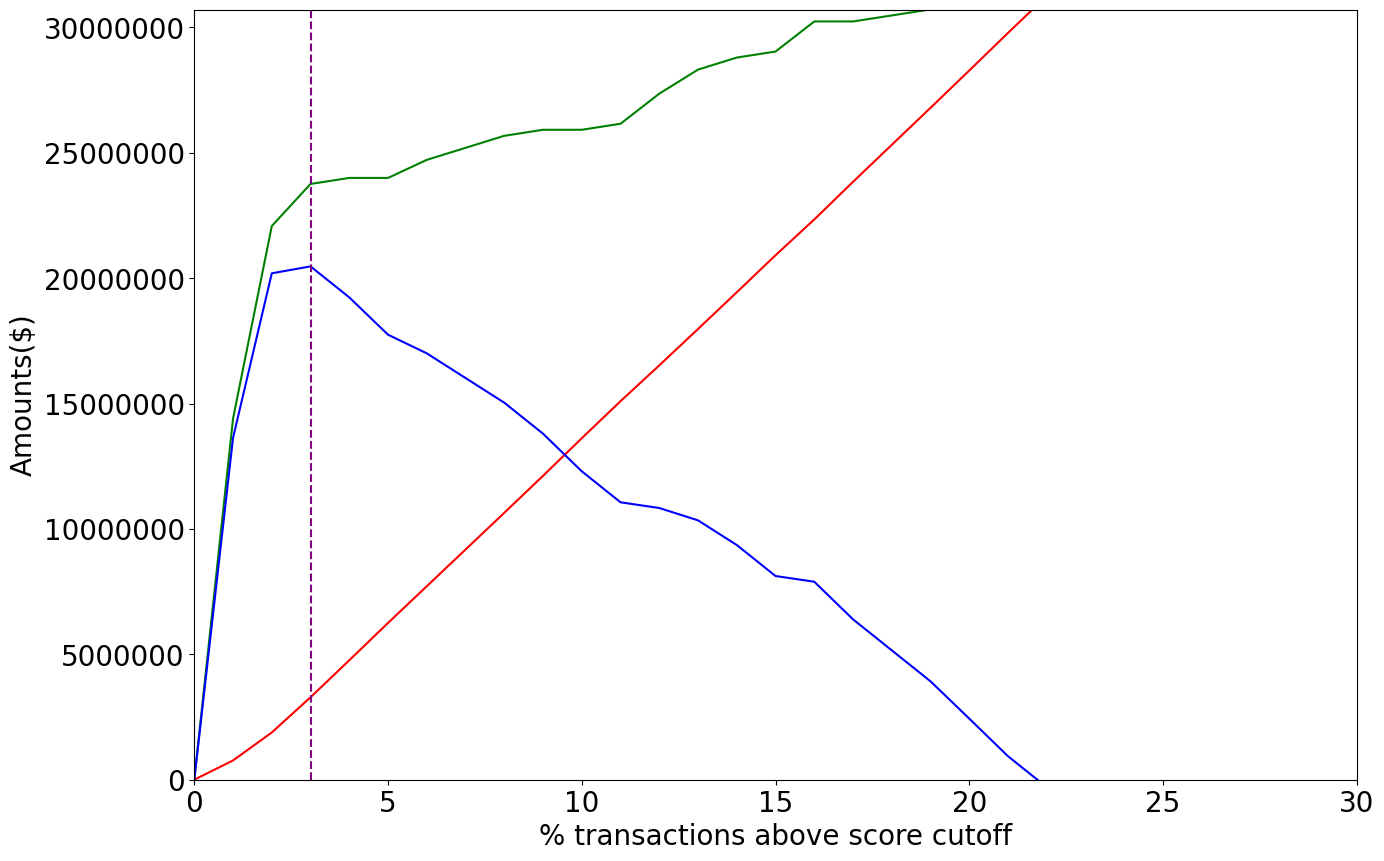

In [82]:
cost_fraud = 400
cost_fp = 20
# xmult: oot is only 2 out of 12 months, and 100,000 sample transactions out of 10 million/year
xoot = 12/2 * 10000000/100000
Financials_oot = pd.DataFrame(np.zeros((101, 3)), columns = ['Fraud Savings','FP Loss','Overall Savings'])
for i in range(101):
    Financials_oot.loc[i, 'Fraud Savings'] = FDR_oot.loc[i, 'cb'] * cost_fraud * xoot
    Financials_oot.loc[i, 'FP Loss'] = FDR_oot.loc[i, 'cg'] * cost_fp * xoot
    Financials_oot.loc[i, 'Overall Savings'] = Financials_oot.loc[i, 'Fraud Savings'] - Financials_oot.loc[i, 'FP Loss']

max_savings = Financials_oot['Overall Savings'].max(0)
max_cutoff = Financials_oot['Overall Savings'].idxmax()
print('Max possible %: '+'{:,}'.format(max_cutoff))
print('Max possible savings: '+'{:,}'.format(max_savings))
yupper = max_savings * 1.5

plt.rcParams.update({'font.size':20})
plt.figure(figsize=(15,10))
plt.plot(Financials_oot['Fraud Savings'], color='green')
plt.plot(Financials_oot['FP Loss'], color='red')
plt.plot(Financials_oot['Overall Savings'], color='blue')
plt.xlim(0,30)
plt.ylim(0,yupper)
plt.ticklabel_format(style='plain')
plt.vlines(x=3,ymin = 0,ymax = yupper, color='purple', linestyle='--')
plt.ylabel('Amounts($)')
plt.xlabel('% transactions above score cutoff')

plt.savefig('savings.png', format='png')

In [83]:
Financials_oot['Overall Savings']

0              0.0
1       13632000.0
2       20196000.0
3       20472000.0
4       19236000.0
          ...     
96     -98556000.0
97     -99792000.0
98    -101028000.0
99    -102528000.0
100   -104016000.0
Name: Overall Savings, Length: 101, dtype: float64